In [10]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import sklearn
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import random
from gensim import corpora

nltk.download('punkt');
nltk.download('stopwords');

data=pd.read_csv("/content/drive/MyDrive/SOC-2021 data/IMDB Dataset.csv")


stop_words=set(stopwords.words('english'))

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

data['review']=data['review'].apply(denoise_text)

def stem_tokenizer(text):
  tokenizer=nltk.RegexpTokenizer(r"\w+")
  stemmer=PorterStemmer()
  return [stemmer.stem(word) for word in tokenizer.tokenize(text) if word.lower() not in stop_words]

data['review']=data['review'].apply(stem_tokenizer)



def make_dict(data):
    review_dict = corpora.Dictionary(data['review'])
    return review_dict


review_dict = make_dict(data)

def indexer(s): 
  return [review_dict.token2id[word] for word in s]

data["review_index"]=data["review"].apply(indexer)

def class_pre(val):
  if val=='positive':
    return 1
  else:
    return 0
data['sentiment_val']=data['sentiment'].apply(class_pre)

processed_data=data.drop(['review','sentiment'],axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import optim

import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

dict_size = len(review_dict)
def review_ohe(review_idex_form):
  seq_len=len(review_idex_form)
  features = torch.zeros((seq_len, dict_size),device=device) 

  for i in range(len(review_idex_form)):
    features[i,review_idex_form[i]]=1

  return features

data_test=processed_data[:10]
#data_test=review_ohe(data_test)
#print(data.review[:10])
print(data_test['review_index'].apply(review_ohe)[5][np.newaxis,:,:].shape)

temporary=data_test['review_index'].apply(review_ohe)


#list_batch=[item for item in temporary]
  
#print(pad_sequence(list_batch,batch_first=True).shape)

def padded_input(tempo):
  list_batch=[item for item in tempo]
  
  return pad_sequence(list_batch,batch_first=True)

print(padded_input(temporary).shape)

def split_train_test(data, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(data['review_index'], 
                                                        data['sentiment_val'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train_df = Y_train.to_frame()
    Y_train_df = Y_train.reset_index()
    Y_test_df = Y_test.to_frame()
    Y_test_df = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test, Y_train_df, Y_test_df

X_train, X_test, Y_train, Y_test, Y_train_df, Y_test_df = split_train_test(processed_data)



Y_train=Y_train.to_numpy()
Y_test=Y_test.to_numpy()

print(Y_train[:10])

y_train=torch.zeros(Y_train.shape[0],device=device,dtype=torch.long)
y_test=torch.zeros(Y_test.shape[0],device=device,dtype=torch.long)

for index in range(Y_train.shape[0]):
  if(Y_train[index]==1):
    y_train[index]=1

for index in range(Y_test.shape[0]):
  if(Y_test[index]==1):
    y_test[index]=1

print(y_train[:10])

def make_target(label):
    if label == 0:
        return torch.tensor([0], dtype=torch.long, device=device)
    else:
        return torch.tensor([1], dtype=torch.long, device=device)


Device available for running: 
cuda
torch.Size([1, 56, 74159])
torch.Size([10, 163, 74159])
Value counts for Train sentiments
0    17512
1    17488
Name: sentiment_val, dtype: int64
Value counts for Test sentiments
1    7512
0    7488
Name: sentiment_val, dtype: int64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
   index                                       review_index
0  36322  [997, 36, 277, 329, 913, 2899, 134, 873, 131, ...
1   4638  [91, 132, 1114, 85, 48, 1711, 268, 417, 1426, ...
2  46808  [497, 527, 3793, 611, 4147, 3247, 2001, 1355, ...
3  38099  [286, 5633, 1889, 2319, 110, 2559, 670, 568, 5...
4  31461  [1036, 230, 286, 1952, 360, 327, 1151, 77, 215...
[1 1 0 0 1 1 1 1 0 1]
tensor([1, 1, 0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')


In [12]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=device)
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return F.softmax(out, dim=1)

# batch_size, epoch and iteration
batch_size = 1
n_iters = 5
"""num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)"""

    
# Create RNN
input_dim = len(review_dict)    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 2   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(model)

RNNModel(
  (rnn): RNN(74159, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)


epoch number   1
0.6926421848007611
epoch number   2
0.6899204789246831
epoch number   3
0.6812082053678377
epoch number   4
0.6440121863722801
epoch number   5
0.6092744935912745


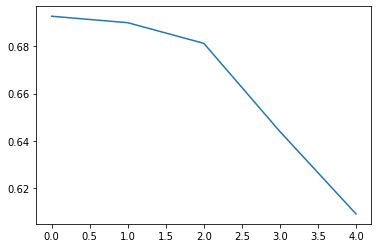

In [13]:
train_loss = []
train_loss_buffer=0

for epoch in range(n_iters):
    print("epoch number   %d" % (epoch+1))
    if (epoch+1) % 25 == 0:
        print("Epoch completed: " + str(epoch+1))
    for index, row in X_train.iterrows():
        optimizer.zero_grad()
        ip_vec = padded_input(review_ohe(row['review_index']))  
        probs = model(ip_vec.unsqueeze(0))
        target = make_target(Y_train_df['sentiment_val'][index])
        loss = error(probs, target)        
        train_loss_buffer+=loss.item()
        loss.backward()
        optimizer.step()
    train_loss.append(train_loss_buffer/len(X_train))
    print(train_loss_buffer/len(X_train))
    train_loss_buffer=0
plt.plot(train_loss)

In [14]:
from sklearn.metrics import classification_report
bow_ff_nn_predictions = []
original_lables_ff_bow = []
with torch.no_grad():
    for index, row in X_test.iterrows():
        ip_vec = padded_input(review_ohe(row['review_index']))  
        probs = model(ip_vec.unsqueeze(0))
        bow_ff_nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow.append(make_target(Y_test_df['sentiment_val'][index]).cpu().numpy()[0])
print(classification_report(original_lables_ff_bow,bow_ff_nn_predictions))

              precision    recall  f1-score   support

           0       0.86      0.51      0.64      7488
           1       0.65      0.92      0.76      7512

    accuracy                           0.71     15000
   macro avg       0.75      0.71      0.70     15000
weighted avg       0.75      0.71      0.70     15000

